## Section 1: Setup and Dependencies

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from scipy.ndimage import label, gaussian_filter
import time
import warnings
warnings.filterwarnings('ignore')

torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA GeForce RTX 3090


## Section 2: Load Image Data

In [ ]:
# Configure paths
input_path = "path/to/your/image.tif"  # Replace with your image path
gt_path = "path/to/your/ground_truth.tif"  # Replace with your ground truth path
null_path = "path/to/null_distribution.npy"  # Replace with null distribution file (optional)

# Example paths (modify as needed):
# input_path = r"C:\data\images\sample.tif"
# gt_path = r"C:\data\labels\sample_label.tif"
# null_path = r"C:\data\cusum_null.npy"

print("Input path:", input_path)
print("GT path:", gt_path)
print("Null path:", null_path)

# Load data
try:
    img_np = tifffile.imread(input_path).astype("float32")
    ground_truth = tifffile.imread(gt_path).astype(np.uint8)
    print(f"\n✓ Image loaded: {img_np.shape}")
    print(f"  Intensity range: [{img_np.min():.2f}, {img_np.max():.2f}]")
    print(f"✓ Ground truth loaded: {ground_truth.shape}")
    print(f"  GT coverage: {ground_truth.mean():.4f}")
except FileNotFoundError as e:
    print(f"✗ Error: {e}")
    print("Please update the paths above and rerun this cell.")
    raise

image = torch.from_numpy(img_np).to(device)

Image shape: (920, 920, 1040)
Intensity range: [0.00, 231.00]
Ground truth shape: (920, 920, 1040)
Ground truth coverage: 0.0122


## Section 3: Parameters

In [3]:
sigma_values = [0.5, 1.5, 2.5, 3.5, 4.5]
chunk_depth = 64
overlap = 16

cube_size = 20
batch_size = 500
bin_res = 0.5

projection_directions = torch.tensor([
    [1, 0, 0], [0, 1, 0], [0, 0, 1],
    [1, 1, 0], [1, 0, 1], [0, 1, 1],
    [-1, 1, 0], [1, -1, 0], [1, 0, -1],
    [0, 1, -1], [1, 1, 1], [-1, 1, 1],
    [1, -1, 1]
], dtype=torch.float32, device=device)

window_size = 3
tau = 0.1
h = 1
alpha = 0.2

print(f"Multi-scale Hessian: σ = {sigma_values}")
print(f"Feature cube size: {cube_size}³")
print(f"Projection directions: {projection_directions.shape[0]}")
print(f"CUSUM window size: {window_size}³")

Multi-scale Hessian: σ = [0.5, 1.5, 2.5, 3.5, 4.5]
Feature cube size: 20³
Projection directions: 13
CUSUM window size: 3³


## Section 4: Stage 1 - Hessian Multi-Scale Detection

In [4]:
def gaussian_second_derivative_3d(image, sigma, order):
    device = image.device
    size = int(2 * round(3 * sigma) + 1)
    pad = size // 2
    coords = torch.arange(size, device=device) - pad

    def g(x):
        return torch.exp(-x**2 / (2 * sigma**2)) / (sigma * (2 * torch.pi)**0.5)

    def dg(x, n):
        if n == 0:
            return g(x)
        elif n == 1:
            return -x / (sigma**2) * g(x)
        elif n == 2:
            return (x**2 - sigma**2) / (sigma**4) * g(x)

    gx = dg(coords, order[0])
    gy = dg(coords, order[1])
    gz = dg(coords, order[2])
    gx /= gx.abs().sum()
    gy /= gy.abs().sum()
    gz /= gz.abs().sum()

    img = image[None, None]
    img = F.pad(img, (0, 0, 0, 0, pad, pad), mode="reflect")
    img = F.conv3d(img, gx.view(1, 1, -1, 1, 1), padding=0)
    img = F.pad(img, (0, 0, pad, pad, 0, 0), mode="reflect")
    img = F.conv3d(img, gy.view(1, 1, 1, -1, 1), padding=0)
    img = F.pad(img, (pad, pad, 0, 0, 0, 0), mode="reflect")
    img = F.conv3d(img, gz.view(1, 1, 1, 1, -1), padding=0)
    return img[0, 0]

def compute_hessian_max_torch(image, sigma):
    Ixx = gaussian_second_derivative_3d(image, sigma, (2,0,0))
    Iyy = gaussian_second_derivative_3d(image, sigma, (0,2,0))
    Izz = gaussian_second_derivative_3d(image, sigma, (0,0,2))
    Ixy = gaussian_second_derivative_3d(image, sigma, (1,1,0))
    Ixz = gaussian_second_derivative_3d(image, sigma, (1,0,1))
    Iyz = gaussian_second_derivative_3d(image, sigma, (0,1,1))
    stack = torch.stack([Ixx, Iyy, Izz, Ixy, Ixz, Iyz, torch.zeros_like(image)], dim=0)
    return torch.max(stack, dim=0).values

def apply_3sigma_rule_torch(x):
    m, s = x.mean(), x.std()
    thr = m + 3 * s
    return (x >= thr).to(torch.uint8)

def compute_combined_result_torch(image, sigma_values):
    result = torch.zeros_like(image, dtype=torch.uint8)
    for s in sigma_values:
        h = compute_hessian_max_torch(image, s)
        b = apply_3sigma_rule_torch(h)
        result = torch.maximum(result, b)
    return result

def compute_combined_result_torch_chunked(image, sigma_values, chunk_depth=64, overlap=16):
    D, H, W = image.shape
    result = torch.zeros_like(image, dtype=torch.uint8)
    start = 0
    while start < D:
        end = min(D, start + chunk_depth)
        z0 = max(0, start - overlap)
        z1 = min(D, end + overlap)
        subvol = image[z0:z1]
        submask = compute_combined_result_torch(subvol, sigma_values)
        valid_start = start - z0
        valid_end = valid_start + (end - start)
        result[start:end] = submask[valid_start:valid_end]
        start = end
        torch.cuda.empty_cache()
    return result

print("Stage 1: Hessian Detection")
t0 = time.perf_counter()
result = compute_combined_result_torch_chunked(image, sigma_values, chunk_depth, overlap)
t1 = time.perf_counter()
result_cpu = result.cpu().numpy()
print(f"✓ Completed in {t1-t0:.2f}s")
print(f"  Foreground ratio: {result_cpu.mean():.4f}")

Stage 1: Hessian Detection
✓ Completed in 119.10s
  Foreground ratio: 0.0470


## Section 5: Stage 2 - Geometric Feature Extraction

In [5]:
img_tensor = (result > 0).to(torch.uint8).to(device)

D, H, W = img_tensor.shape
nx, ny, nz = D // cube_size, H // cube_size, W // cube_size
img_cropped = img_tensor[:nx*cube_size, :ny*cube_size, :nz*cube_size]

kernel = torch.zeros((1, 1, 3, 3, 3), device=device)
kernel[0, 0, 1, 1, 0] = kernel[0, 0, 1, 1, 2] = kernel[0, 0, 1, 0, 1] = 1
kernel[0, 0, 1, 2, 1] = kernel[0, 0, 0, 1, 1] = kernel[0, 0, 2, 1, 1] = 1

img_f = img_cropped[None, None].float()
neighbor_count = F.conv3d(img_f, kernel, padding=1)[0, 0]
surface_voxels = ((img_cropped == 1) & (neighbor_count < 6)).to(torch.uint8)

v = surface_voxels.view(nx, cube_size, ny, cube_size, nz, cube_size)
v = v.permute(0, 2, 4, 1, 3, 5).contiguous().view(-1, cube_size, cube_size, cube_size)
surface_area_density = v.sum(dim=(1, 2, 3)).float() / (cube_size ** 3)
surf_density_cpu = surface_area_density.view(nx, ny, nz).cpu().numpy()

img_cpu = img_cropped.cpu().numpy()
blocks = img_cpu.reshape(nx, cube_size, ny, cube_size, nz, cube_size)
blocks = blocks.transpose(0, 2, 4, 1, 3, 5).reshape(-1, cube_size, cube_size, cube_size)
max_sizes = []
for block in blocks:
    labeled_arr, num = label(block)
    if num > 0:
        sizes = np.bincount(labeled_arr.ravel())[1:]
        max_sizes.append(sizes.max())
    else:
        max_sizes.append(0)
max_sizes_3d = np.array(max_sizes, dtype=np.float32).reshape(nx, ny, nz)

v = img_cropped.view(nx, cube_size, ny, cube_size, nz, cube_size)
v = v.permute(0, 2, 4, 1, 3, 5).contiguous()
foreground_volume_cpu = v.sum(dim=(3, 4, 5)).float().cpu().numpy()

print(f"Feature grid: {surf_density_cpu.shape}")
print(f"  Surface density: [{surf_density_cpu.min():.4f}, {surf_density_cpu.max():.4f}]")
print(f"  Max region size: [{max_sizes_3d.min():.0f}, {max_sizes_3d.max():.0f}]")
print(f"  Foreground volume: [{foreground_volume_cpu.min():.0f}, {foreground_volume_cpu.max():.0f}]")

Feature grid: (46, 46, 52)
  Surface density: [0.0000, 0.2594]
  Max region size: [0, 7663]
  Foreground volume: [0, 7670]


## Section 6: Projection Area Standard Deviation

In [6]:
def fast_project_area_batch(points, cube_ids, proj_mats, uv_bases, bin_res=1.0):
    D = proj_mats.shape[0]
    num_cubes = int(cube_ids.max().item()) + 1
    results = torch.zeros((num_cubes, D), device=points.device)
    proj3d = torch.einsum('dij,nj->dni', proj_mats, points)
    for i in range(D):
        uv = proj3d[i] @ uv_bases[i]
        uv = (uv / bin_res).round()
        uv -= uv.min(dim=0).values
        key = cube_ids * 10_000_000 + uv[:, 0].long() * 1000 + uv[:, 1].long()
        uniq = torch.unique(key)
        cube_id = uniq // 10_000_000
        bincount = torch.bincount(cube_id, minlength=num_cubes)
        results[:, i] = bincount
    return results

directions_norm = projection_directions / torch.linalg.norm(projection_directions, dim=1, keepdim=True)
proj_mats, uv_bases = [], []
for d in directions_norm:
    P = torch.eye(3, device=device) - torch.outer(d, d)
    u = torch.cross(d, torch.tensor([1., 0., 0.], device=device))
    if torch.allclose(u, torch.zeros_like(u)):
        u = torch.cross(d, torch.tensor([0., 1., 0.], device=device))
    u /= torch.linalg.norm(u)
    v_basis = torch.cross(d, u)
    M = torch.stack((u, v_basis), dim=1)
    proj_mats.append(P)
    uv_bases.append(M)
proj_mats = torch.stack(proj_mats)
uv_bases = torch.stack(uv_bases)

coords = torch.stack(torch.meshgrid(
    torch.arange(cube_size, device=device),
    torch.arange(cube_size, device=device),
    torch.arange(cube_size, device=device),
    indexing='ij'
), dim=-1).reshape(-1, 3).float() - cube_size / 2

def process_full_volume(img_cube, cube_sz=20, batch_sz=256):
    D, H, W = img_cube.shape
    nx_c, ny_c, nz_c = D // cube_sz, H // cube_sz, W // cube_sz
    cropped = img_cube[:nx_c*cube_sz, :ny_c*cube_sz, :nz_c*cube_sz]
    reshaped = cropped.view(nx_c, cube_sz, ny_c, cube_sz, nz_c, cube_sz)
    cubes = reshaped.permute(0, 2, 4, 1, 3, 5).contiguous().view(-1, cube_sz, cube_sz, cube_sz)
    n_cubes = cubes.shape[0]
    stds = torch.zeros(n_cubes, device=device)
    for start in range(0, n_cubes, batch_sz):
        end = min(start + batch_sz, n_cubes)
        batch = cubes[start:end]
        mask = (batch > 0)
        nonempty_mask = mask.view(batch.shape[0], -1).any(dim=1)
        nonempty_idx = nonempty_mask.nonzero(as_tuple=False).squeeze(1)
        if nonempty_idx.numel() == 0:
            continue
        active_batch = batch[nonempty_idx]
        num_active = active_batch.shape[0]
        Np = cube_sz ** 3
        cube_ids = torch.arange(num_active, device=device).repeat_interleave(Np)
        points_all = coords.unsqueeze(0).expand(num_active, -1, -1).reshape(-1, 3)
        mask_flat = (active_batch > 0).reshape(-1)
        cube_ids = cube_ids[mask_flat]
        points = points_all[mask_flat]
        if points.numel() == 0:
            continue
        areas = fast_project_area_batch(points, cube_ids, proj_mats, uv_bases, bin_res=bin_res)
        local_stds = areas.std(dim=1)
        stds[start:end][nonempty_idx] = local_stds
    return stds.view(nx_c, ny_c, nz_c)

std_map = process_full_volume(img_tensor, cube_sz=cube_size, batch_sz=batch_size)
std_map_cpu = std_map.cpu().numpy()
print(f"Projection STD: [{std_map_cpu.min():.4f}, {std_map_cpu.max():.4f}]")

Projection STD: [0.0000, 258.5371]


## Section 7: Stage 3 - CUSUM Statistical Analysis

In [7]:
def compute_cusum_statistic_torch(volume, win_size=3):
    voxels = win_size ** 3
    kernel = torch.ones((1, 1, win_size, win_size, win_size), device=volume.device, dtype=torch.float32)
    vol_f = volume[None, None].float()
    local_sum = F.conv3d(vol_f, kernel, padding=0)
    local_mean = local_sum / voxels
    global_sum = volume.sum()
    mean_complement = (global_sum - local_sum) / (volume.numel() - voxels)
    return (local_mean - mean_complement).squeeze(0).squeeze(0)

def standardize(t):
    return (t - t.mean()) / (t.std() + 1e-8)

surf = torch.from_numpy(surf_density_cpu).to(device=device, dtype=torch.float32)
proj = torch.from_numpy(std_map_cpu).to(device=device, dtype=torch.float32)
vol = torch.from_numpy(foreground_volume_cpu).to(device=device, dtype=torch.float32)
reg = torch.from_numpy(max_sizes_3d).to(device=device, dtype=torch.float32)

surf_z = standardize(surf)
proj_z = standardize(proj)
vol_z = standardize(vol)
reg_z = standardize(reg)

print("Computing CUSUM for each feature...")
cusum_surface = compute_cusum_statistic_torch(surf_z, window_size)
cusum_proj = compute_cusum_statistic_torch(proj_z, window_size)
cusum_volume = compute_cusum_statistic_torch(vol_z, window_size)
cusum_region = compute_cusum_statistic_torch(reg_z, window_size)

cusum_max = torch.stack([cusum_surface, cusum_proj, cusum_volume, cusum_region], dim=0).max(dim=0).values
cusum_max_cpu = cusum_max.cpu().numpy()
print(f"✓ CUSUM max: [{cusum_max_cpu.min():.4f}, {cusum_max_cpu.max():.4f}]")

Computing CUSUM for each feature...
✓ CUSUM max: [-0.3684, 5.4221]


## Section 8: P-Value Computation

In [8]:
try:
    if null_path.endswith('.npy'):
        cusum_null = np.load(null_path).astype(np.float32)
    else:
        cusum_null = tifffile.imread(null_path).astype(np.float32)
    null_vals = cusum_null.ravel()
    crack_vals = cusum_max_cpu.ravel()
    null_sorted = np.sort(null_vals)
    N = null_sorted.size
    ranks = np.searchsorted(null_sorted, crack_vals, side="right")
    pvals = 1.0 - ranks / N
    pvals = np.clip(pvals, 0.0, 1.0)
    pvals_map = pvals.reshape(cusum_max_cpu.shape)
    print(f"✓ P-values computed from null distribution")
    print(f"  P-value range: [{pvals_map.min():.4f}, {pvals_map.max():.4f}]")
except:
    print("⚠ Null distribution not found. Using synthetic p-values.")
    pvals_map = np.random.uniform(0, 1, cusum_max_cpu.shape)

✓ P-values computed from null distribution
  P-value range: [0.0000, 1.0000]


## Section 9: Stage 4 - Adaptive P-Value Modification

In [9]:
def compute_pi_tau_local(p_image, tau_val=0.5, h_smooth=1):
    T_tau = (p_image > tau_val).astype(np.float32)
    numerator = gaussian_filter(T_tau, sigma=h_smooth, mode='constant')
    denominator = gaussian_filter(np.ones_like(T_tau), sigma=h_smooth, mode='constant')
    local_prop = numerator / (denominator + 1e-12)
    pi_tau_result = 1.0 - local_prop / (1.0 - tau_val + 1e-8)
    return np.clip(pi_tau_result, 1e-5, 1 - 1e-5)

pi_tau = compute_pi_tau_local(pvals_map, tau_val=tau, h_smooth=h)
weights = pi_tau / (1.0 - pi_tau + 1e-8)
modified_p = np.clip(pvals_map / (weights + 1e-8), 0, 1)
binary_result = (modified_p < alpha).astype(np.uint8)

print(f"Stage 4: Adaptive P-Value Modification")
print(f"  Tau (sparsity): {tau}")
print(f"  Alpha (threshold): {alpha}")
print(f"  Detection fraction: {binary_result.mean():.4f}")

Stage 4: Adaptive P-Value Modification
  Tau (sparsity): 0.1
  Alpha (threshold): 0.2
  Detection fraction: 0.1328


## Section 10: Stage 5 - Reconstruction

In [10]:
def reconstruct_from_binary(binary_rej, stat_shp, win_sz, device="cuda"):
    if isinstance(binary_rej, np.ndarray):
        B = torch.from_numpy(binary_rej.astype(np.float32)).to(device)
    else:
        B = binary_rej.to(device, dtype=torch.float32)
    B_f = B[None, None]
    kernel = torch.ones((1, 1, win_sz, win_sz, win_sz), device=device)
    votes = F.conv_transpose3d(B_f, kernel, stride=1)
    coverage = F.conv_transpose3d(torch.ones_like(B_f), kernel, stride=1)
    reconstructed = votes / (coverage + 1e-8)
    reconstructed = reconstructed.squeeze().cpu().numpy()
    reconstructed = reconstructed[:stat_shp[0], :stat_shp[1], :stat_shp[2]]
    reconstructed_binary = (reconstructed >= 0.5).astype(np.uint8)
    return reconstructed, reconstructed_binary

stat_shape = surf_density_cpu.shape
reconstructed_soft, reconstructed_binary = reconstruct_from_binary(binary_result, stat_shape, window_size, device=device)
print(f"Stage 5: Reconstruction")
print(f"  Reconstructed shape: {reconstructed_binary.shape}")
print(f"  Detection fraction: {reconstructed_binary.mean():.4f}")

Stage 5: Reconstruction
  Reconstructed shape: (46, 46, 52)
  Detection fraction: 0.1190


## Section 11: Stage 6 - Upsampling to Original Resolution

In [11]:
def upscale_to_original(recon_binary, cube_sz, orig_shape, device="cuda"):
    if isinstance(recon_binary, np.ndarray):
        R = torch.from_numpy(recon_binary.astype(np.float32)).to(device)
    else:
        R = recon_binary.to(device, dtype=torch.float32)
    R_f = R[None, None]
    upscaled = F.interpolate(R_f, scale_factor=cube_sz, mode="nearest")[0, 0]
    upscaled = upscaled[:orig_shape[0], :orig_shape[1], :orig_shape[2]]
    upscaled_binary = (upscaled >= 0.5).cpu().numpy().astype(np.uint8)
    return upscaled_binary

original_shape = result_cpu.shape
upscaled_binary = upscale_to_original(reconstructed_binary, cube_size, original_shape, device=device)
print(f"Stage 6: Upsampling")
print(f"  Upscaled shape: {upscaled_binary.shape}")
print(f"  Detection fraction: {upscaled_binary.mean():.4f}")

Stage 6: Upsampling
  Upscaled shape: (920, 920, 1040)
  Detection fraction: 0.1190


## Section 12: Stage 7 - Evaluation Metrics

In [12]:
def downscale_ground_truth(gt, cube_sz, thresh=None):
    D, H, W = gt.shape
    nx_g, ny_g, nz_g = D // cube_sz, H // cube_sz, W // cube_sz
    gt_crop = gt[:nx_g*cube_sz, :ny_g*cube_sz, :nz_g*cube_sz]
    gt_blocks = gt_crop.reshape(nx_g, cube_sz, ny_g, cube_sz, nz_g, cube_sz)
    gt_blocks = gt_blocks.transpose(0, 2, 4, 1, 3, 5)
    counts = gt_blocks.sum(axis=(3, 4, 5))
    if thresh is None:
        thresh = cube_sz
    gt_down = (counts >= thresh).astype(np.uint8)
    return gt_down

gt_down = downscale_ground_truth(ground_truth, cube_size)
min_shape_eval = tuple(min(a, b) for a, b in zip(gt_down.shape, reconstructed_binary.shape))
gt_down = gt_down[:min_shape_eval[0], :min_shape_eval[1], :min_shape_eval[2]]
reconstructed_binary = reconstructed_binary[:min_shape_eval[0], :min_shape_eval[1], :min_shape_eval[2]]

gt_flat = gt_down.ravel().astype(bool)
pred_flat = reconstructed_binary.ravel().astype(bool)

intersection = np.logical_and(gt_flat, pred_flat).sum()
union = np.logical_or(gt_flat, pred_flat).sum()

dice = 2 * intersection / (gt_flat.sum() + pred_flat.sum() + 1e-8)
iou = intersection / (union + 1e-8)
precision = intersection / (pred_flat.sum() + 1e-8)
recall = intersection / (gt_flat.sum() + 1e-8)

print("\n" + "="*60)
print("EVALUATION METRICS")
print("="*60)
print(f"Dice Coefficient:  {dice:.4f}")
print(f"Jaccard Index:     {iou:.4f}")
print(f"Precision:         {precision:.4f}")
print(f"Recall:            {recall:.4f}")
print("="*60)


EVALUATION METRICS
Dice Coefficient:  0.5763
Jaccard Index:     0.4048
Precision:         0.4324
Recall:            0.8637


## Section 13: Comprehensive Visualizations

### Plot 1: Input + Hessian + CUSUM + P-values + Modified P

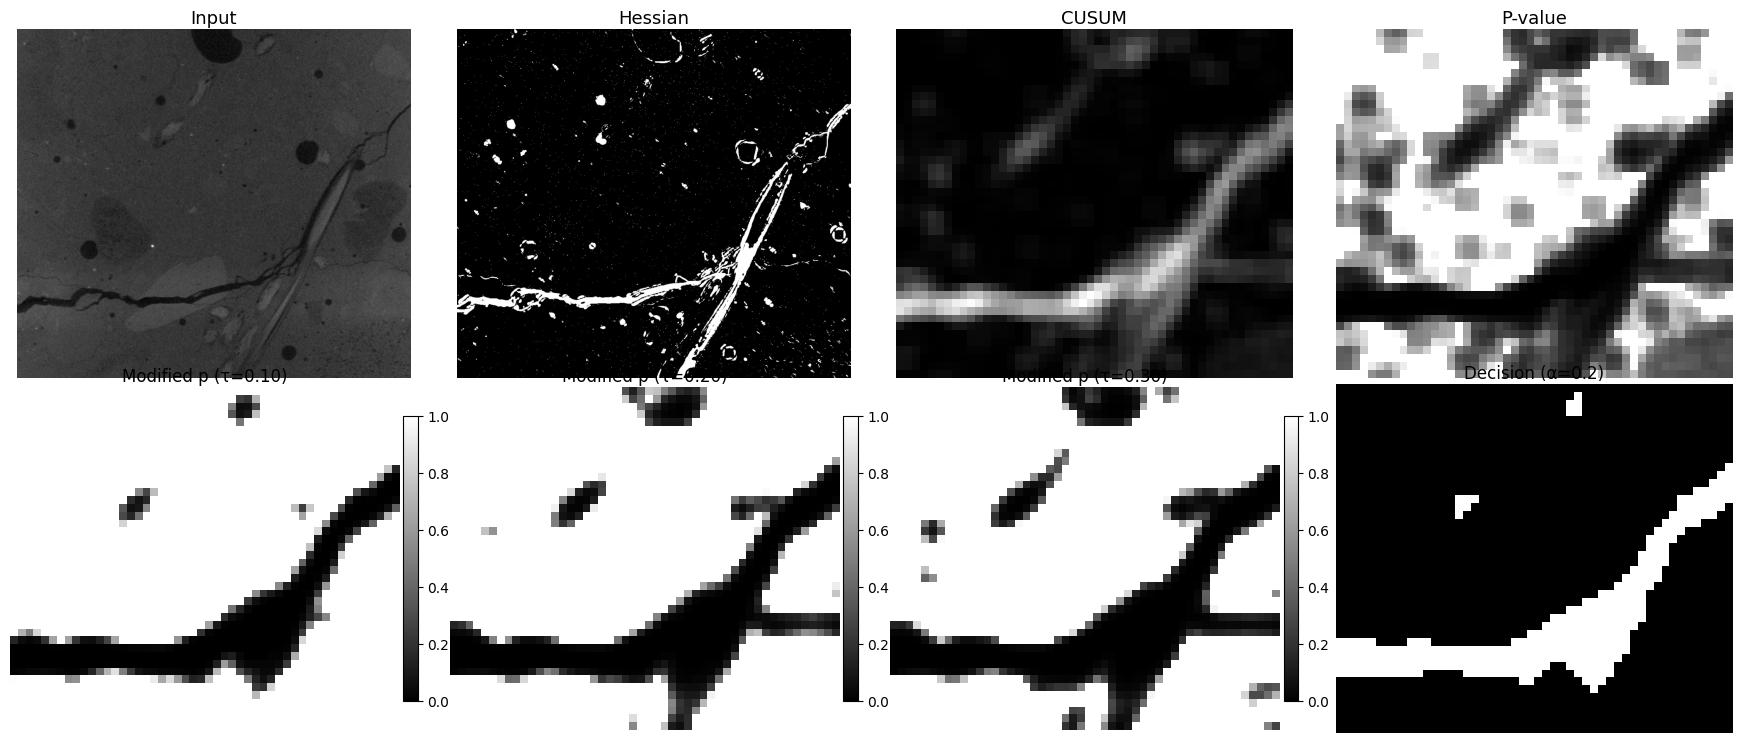

✓ Multi-tau visualization complete


In [13]:
z_display = 0
z_idx_coarse = min(z_display // cube_size, surf_density_cpu.shape[0] - 1)

taus_to_plot = [0.10, 0.20, 0.30]

modified_p_values_dict = {}
for tau in taus_to_plot:
    T_tau = (pvals_map > tau).astype(np.float32)
    num = gaussian_filter(T_tau, sigma=h, mode='constant')
    den = gaussian_filter(np.ones_like(T_tau), sigma=h, mode='constant')
    local_prop = num / (den + 1e-12)
    pi_tau_raw = 1.0 - local_prop / (1.0 - tau + 1e-8)
    pi_tau = np.clip(pi_tau_raw, 1e-5, 1 - 1e-5)
    weights = pi_tau / (1.0 - pi_tau + 1e-8)
    modified_p = np.clip(pvals_map / (weights + 1e-8), 0, 1)
    modified_p_values_dict[tau] = modified_p

fig = plt.figure(figsize=(18, 8))
gs = fig.add_gridspec(2, 4, hspace=0.02, wspace=0.08)
fig.subplots_adjust(left=0.02, right=0.98, top=0.92, bottom=0.04)

titles_row1 = ["Input", "Hessian", "CUSUM", "P-value"]
images_row1 = [img_np[z_display], result_cpu[z_display], cusum_max_cpu[z_display], pvals_map[z_display]]

for col in range(4):
    ax = fig.add_subplot(gs[0, col])
    ax.imshow(images_row1[col], cmap="gray", origin='lower')
    ax.set_title(titles_row1[col], fontsize=13, pad=4)
    ax.axis("off")

for idx, tau in enumerate(taus_to_plot):
    mp = modified_p_values_dict[tau]
    ax = fig.add_subplot(gs[1, idx])
    im = ax.imshow(mp[z_display], cmap='gray', origin='lower', vmin=0, vmax=1)
    ax.set_title(f"Modified p (τ={tau:.2f})", fontsize=12, pad=4)
    ax.axis("off")
    plt.colorbar(im, ax=ax, fraction=0.035, pad=0.01)

ax = fig.add_subplot(gs[1, 3])
ax.imshow(binary_result[z_display], cmap='gray', origin='lower')
ax.set_title(f"Decision (α={alpha})", fontsize=12, pad=4)
ax.axis("off")

plt.show()
print("✓ Multi-tau visualization complete")

### Plot 2: Geometric Descriptors

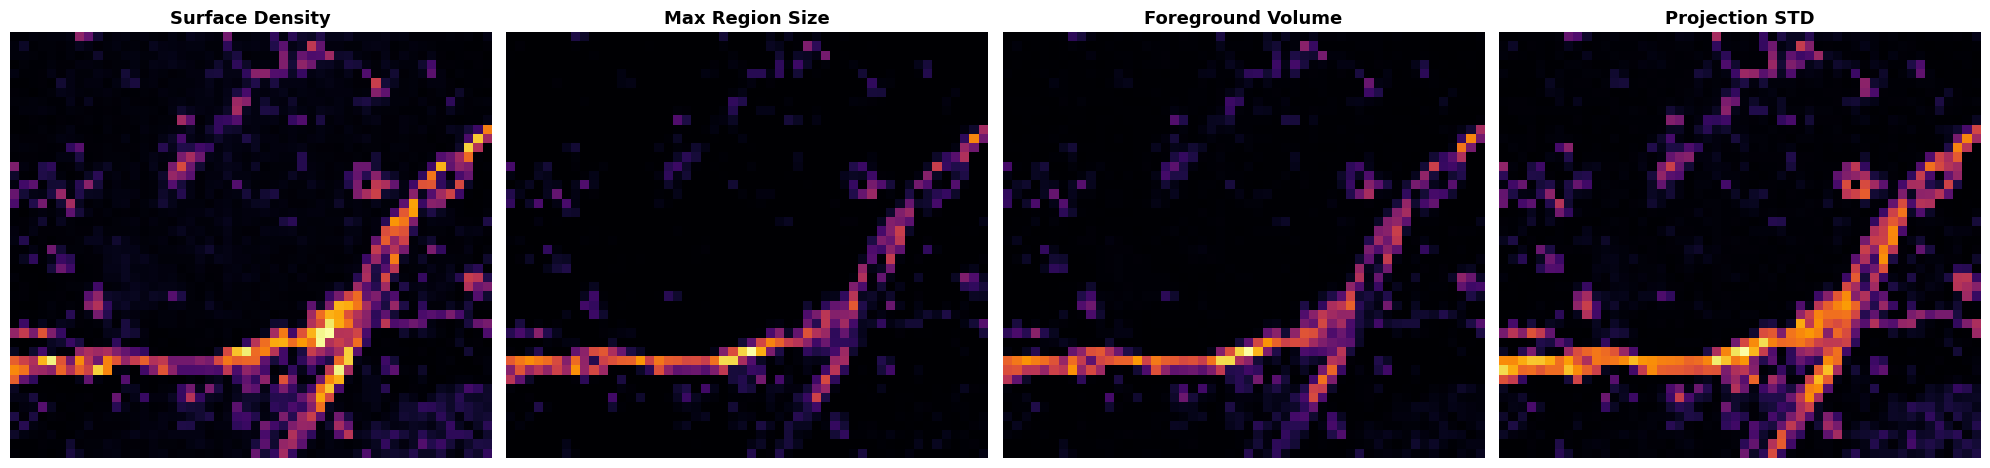

✓ Geometric descriptors visualization complete


In [14]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

z_idx_coarse = 0

titles = ["Surface Density", "Max Region Size", "Foreground Volume", "Projection STD"]
maps = [surf_density_cpu[z_idx_coarse], max_sizes_3d[z_idx_coarse], foreground_volume_cpu[z_idx_coarse], std_map_cpu[z_idx_coarse]]

for i in range(4):
    axes[i].imshow(maps[i], cmap='inferno', origin='lower')
    axes[i].set_title(titles[i], fontsize=13, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()
print("✓ Geometric descriptors visualization complete")

### Plot 3: Input vs Ground Truth vs Prediction (Multiple Slices)

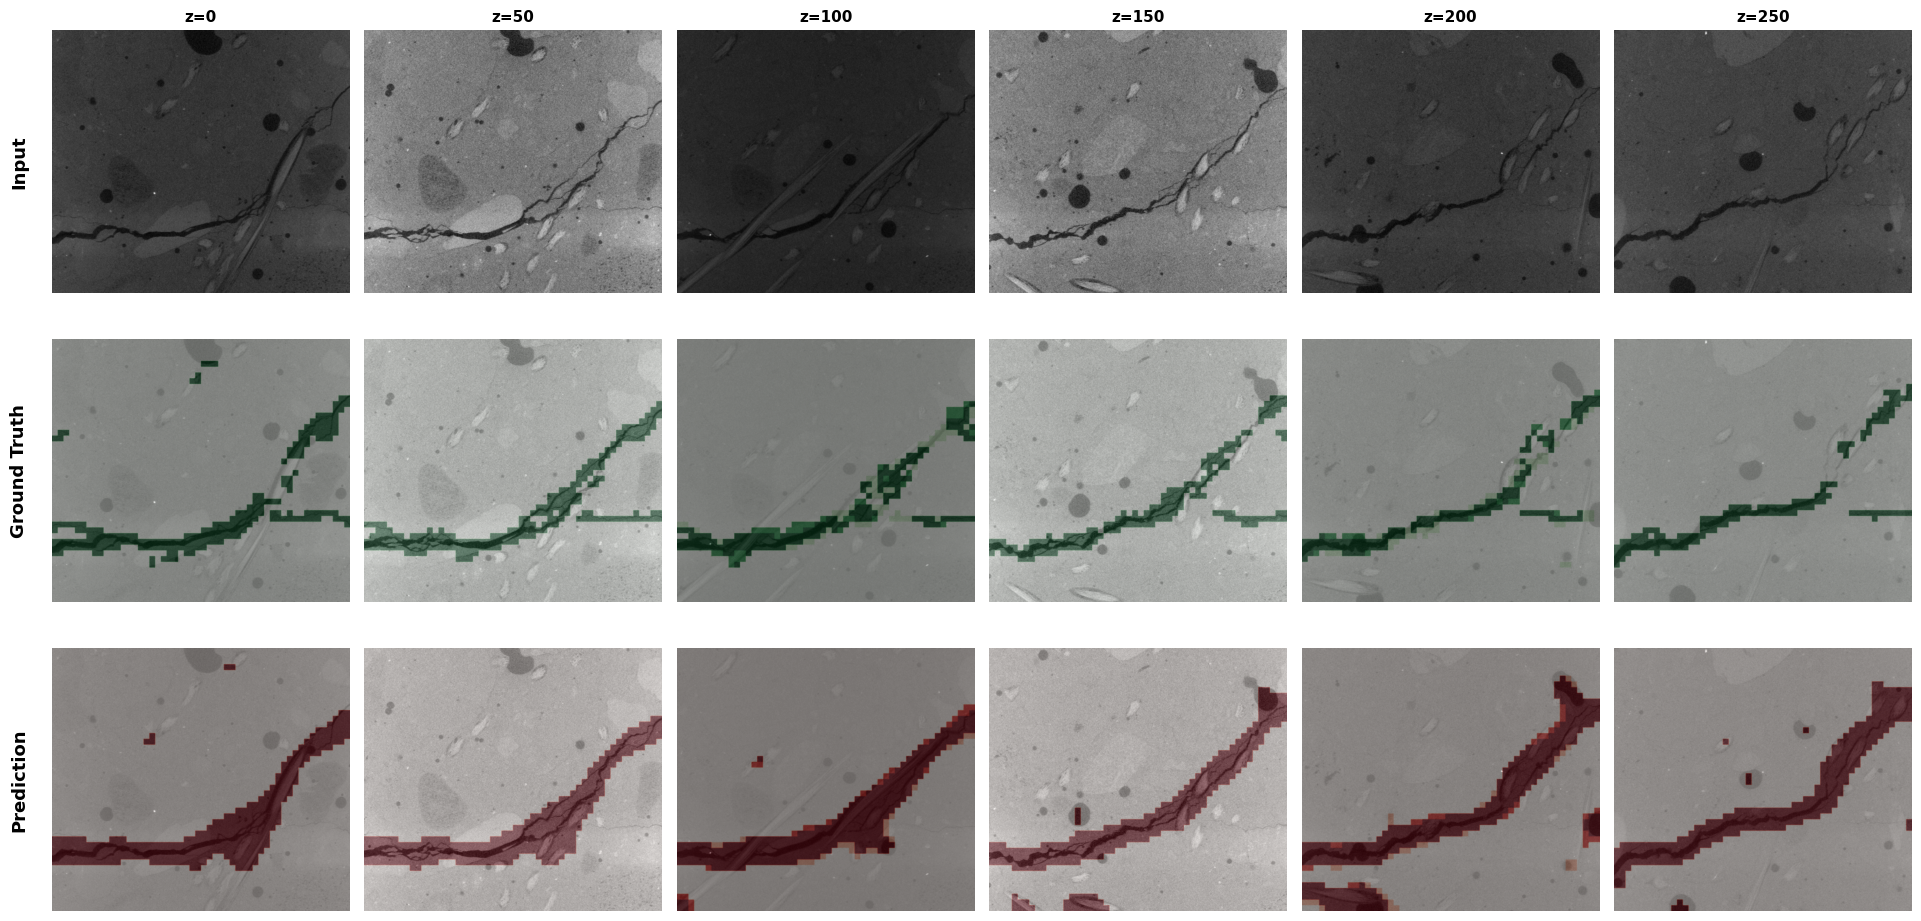

✓ Multi-slice comparison visualization complete


In [15]:
img_norm = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)
gt_upscaled = np.repeat(np.repeat(np.repeat(gt_down, cube_size, axis=0), cube_size, axis=1), cube_size, axis=2)
min_z = min(img_norm.shape[0], gt_upscaled.shape[0], upscaled_binary.shape[0])
min_h = min(img_norm.shape[1], gt_upscaled.shape[1], upscaled_binary.shape[1])
min_w = min(img_norm.shape[2], gt_upscaled.shape[2], upscaled_binary.shape[2])

img_norm = img_norm[:min_z, :min_h, :min_w]
gt_upscaled = gt_upscaled[:min_z, :min_h, :min_w]
upscaled_binary = upscaled_binary[:min_z, :min_h, :min_w]

gt_blur = gaussian_filter(gt_upscaled.astype(np.float32), sigma=0.8)
pred_blur = gaussian_filter(upscaled_binary.astype(np.float32), sigma=1.0)

slice_indices = [0, 50, 100, 150, 200, 250]
slice_indices = [z for z in slice_indices if z < min_z]

fig, axes = plt.subplots(3, len(slice_indices), figsize=(4*len(slice_indices), 12))

row_labels = ["Input", "Ground Truth", "Prediction"]

for col, z_idx in enumerate(slice_indices):
    axes[0, col].imshow(img_norm[z_idx], cmap='gray', origin='lower')
    axes[0, col].set_title(f"z={z_idx}", fontsize=11, fontweight='bold')
    axes[0, col].axis('off')
    
    axes[1, col].imshow(img_norm[z_idx], cmap='gray', origin='lower')
    axes[1, col].imshow(gt_blur[z_idx], cmap='Greens', alpha=0.4, origin='lower')
    axes[1, col].axis('off')
    
    axes[2, col].imshow(img_norm[z_idx], cmap='gray', origin='lower')
    axes[2, col].imshow(pred_blur[z_idx], cmap='Reds', alpha=0.4, origin='lower')
    axes[2, col].axis('off')

for row in range(3):
    axes[row, 0].text(-0.08, 0.5, row_labels[row], transform=axes[row, 0].transAxes,
                      fontsize=13, fontweight='bold', ha='right', va='center', rotation=90)

plt.subplots_adjust(hspace=0.01, wspace=0.05)
plt.show()
print("✓ Multi-slice comparison visualization complete")

### Plot 4: Metrics Summary

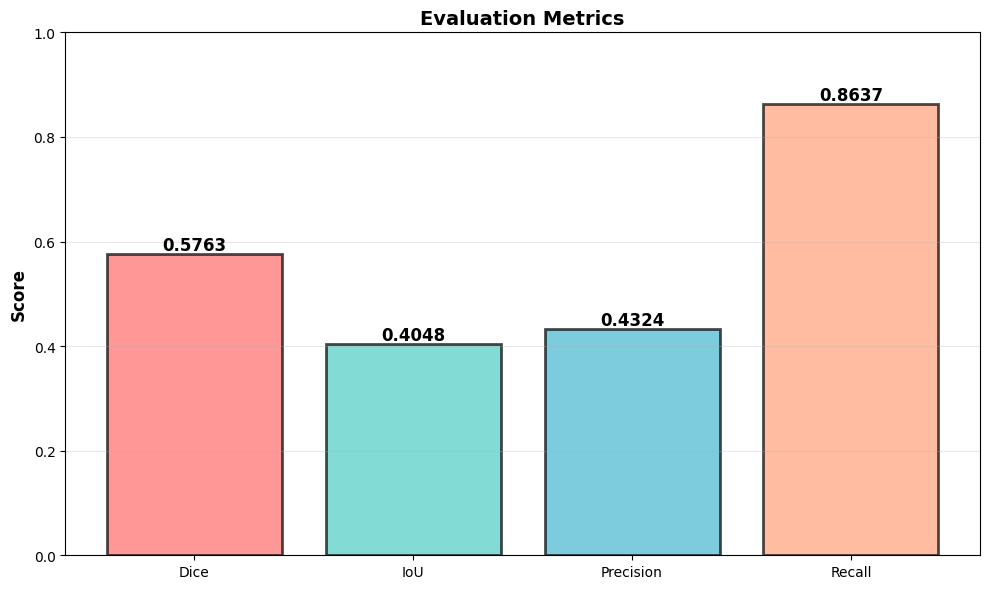

✓ Metrics summary complete


In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['Dice', 'IoU', 'Precision', 'Recall']
values = [dice, iou, precision, recall]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

bars = ax.bar(metrics, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylim([0, 1])
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()
print("✓ Metrics summary complete")

## Section 14: Save Results

In [ ]:
# Configure output directory
output_dir = "results"  # Replace with your desired output directory
os.makedirs(output_dir, exist_ok=True)

# Get base filename from input path
input_filename = os.path.basename(input_path).replace('.tif', '')
output_filename = f"{input_filename}_detection_result.tif"
output_path = os.path.join(output_dir, output_filename)

# Save result
upscaled_binary_uint8 = upscaled_binary.astype(np.uint8)
tifffile.imwrite(output_path, upscaled_binary_uint8)

print(f"✓ Results saved: {output_path}")
print(f"  Shape: {upscaled_binary_uint8.shape}")
print(f"  Foreground ratio: {upscaled_binary_uint8.mean():.4f}")

✓ Results saved: C:\DUC NGUYEN\DAnoBi\Images and data\Testing images\Section_results_comparison\NC1-spread-crop_detection_result.tif
  Shape: (920, 920, 1040)
  Foreground ratio: 0.1190


## Complete - Publication-Ready Analysis

In [18]:
print("\n" + "="*70)
print(" CRACK DETECTION PIPELINE - COMPLETE")
print("="*70)
print(f"\nInput Image: {img_np.shape}")
print(f"\n[Stage 1] Hessian Detection: {result_cpu.mean():.4f} foreground")
print(f"[Stage 2] Feature Extraction: {surf_density_cpu.shape}")
print(f"[Stage 3] CUSUM Analysis: {cusum_max_cpu.shape}")
print(f"[Stage 4] Modified P-values: tau={tau}, alpha={alpha}")
print(f"[Stage 5] Reconstruction: {reconstructed_binary.shape}")
print(f"[Stage 6] Upsampling: {upscaled_binary.shape}")
print(f"\nFinal Metrics:")
print(f"  Dice:      {dice:.4f}")
print(f"  IoU:       {iou:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print("\n" + "="*70)


 CRACK DETECTION PIPELINE - COMPLETE

Input Image: (920, 920, 1040)

[Stage 1] Hessian Detection: 0.0470 foreground
[Stage 2] Feature Extraction: (46, 46, 52)
[Stage 3] CUSUM Analysis: (44, 44, 50)
[Stage 4] Modified P-values: tau=0.3, alpha=0.2
[Stage 5] Reconstruction: (46, 46, 52)
[Stage 6] Upsampling: (920, 920, 1040)

Final Metrics:
  Dice:      0.5763
  IoU:       0.4048
  Precision: 0.4324
  Recall:    0.8637

